In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from image import *
from psfmodel import *
from utils import *
from infer import *

In [2]:
import matplotlib.pyplot as plt
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
plt.rcParams['figure.dpi'] = 100

In [4]:
Npix = 30
super_factor = 3.

In [5]:
image_obs = PixelImage(Npix, Npix)
image_super = PixelImage(Npix, Npix, dx=1./super_factor, dy=1./super_factor)
S = supersampling_matrix(image_super, image_obs)

In [6]:
print (image_obs.shape, image_super.shape, S.shape)

(30, 30) (90, 90) (900, 8100)


In [7]:
Nsource = 10*2
np.random.seed(124)
norms = np.ones(Nsource)
norms = 10**np.random.rand(Nsource)
xcenters = np.random.rand(Nsource) * image_super.xmax
ycenters = np.random.rand(Nsource) * image_super.ymax
sigma = 1.

In [8]:
image_super.Z = simulate_gaussian_sources(image_super, norms, xcenters, ycenters, sigma)
Zobs = super_to_obs(image_super.Z, image_obs)

In [9]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*image_obs.shape)*sigmaerr
image_obs.Z = Zobs + Zerr

In [29]:
use_photocenter = True
xcenters_guess, ycenters_guess, fluxes_guess = np.array([]), np.array([]), np.array([])
for x,y in zip(xcenters, ycenters):
    idx_ap = image_obs.aperture_flux(x, y, 3.)
    flux_ap = image_obs.Z[idx_ap]
    x_ap = image_obs.X[idx_ap]
    y_ap = image_obs.Y[idx_ap]
    if use_photocenter:
        xcenters_guess = np.append(xcenters_guess, np.average(x_ap, weights=flux_ap))
        ycenters_guess = np.append(ycenters_guess, np.average(y_ap, weights=flux_ap))
    else:
        xcenters_guess = np.append(xcenters_guess, x)
        ycenters_guess = np.append(ycenters_guess, y)
    fluxes_guess = np.append(fluxes_guess, np.sum(flux_ap))   
lnfluxes_guess = np.log(fluxes_guess)

idx_anchor = np.argmax(lnfluxes_guess)
#idx_anchor = 0
print ("# anchor source: %d."%idx_anchor)

# anchor source: 8.


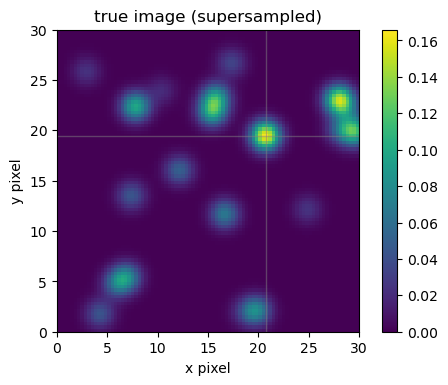

In [30]:
idx_anchor = 13
plot_image(image_super, title='true image (supersampled)',
          xcenters=xcenters[idx_anchor:idx_anchor+1],
          ycenters=ycenters[idx_anchor:idx_anchor+1])

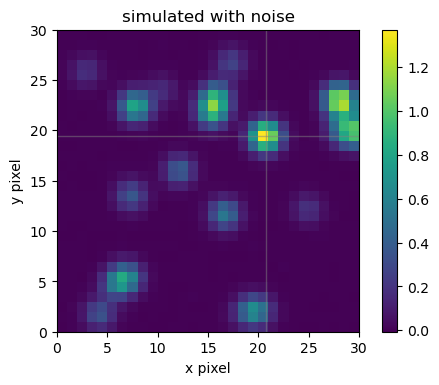

In [31]:
plot_image(image_obs, title='simulated with noise',
          xcenters=xcenters[idx_anchor:idx_anchor+1],
          ycenters=ycenters[idx_anchor:idx_anchor+1])

In [55]:
np.random.seed(321)
perturb = np.random.randn(Nsource)*0.5
perturb[idx_anchor] = 0.
xcenters_guess += perturb
ycenters_guess -= perturb
print (perturb)

[ 0.08625973  0.81774127  0.0186682  -0.44207484 -0.57159613 -0.31068302
 -0.67432479 -0.40986552 -0.06712695  0.79980002 -0.14180182 -0.25316991
  0.03445421  0.         -0.8195478  -0.15632972 -0.43563321 -0.2283412
 -0.06123336 -0.22553115]


In [56]:
xcenters_guess - xcenters

array([ 8.70530685e-01,  9.98584561e-01,  2.53996635e-02, -4.42153837e-01,
       -1.06455901e-01, -7.21445576e-01, -7.85558661e-01, -1.30473416e-01,
       -4.91232298e-01, -1.17107164e-02, -5.14845149e-01, -2.38514604e-01,
        6.15845734e-02, -8.98172288e-04, -4.85385954e-01, -1.40742797e-01,
       -1.64922473e+00, -8.74048527e-02, -2.95009758e-01, -3.29331135e-02])

In [57]:
xext, yext = 7., 7.
dx, dy = 1./3., 1./3.
gridpsf = GridPSFModel(xext, yext, dx, dy)

PSF grid shape: (21, 21)
x centers: [-3.33333333 -3.         -2.66666667 -2.33333333 -2.         -1.66666667
 -1.33333333 -1.         -0.66666667 -0.33333333  0.          0.33333333
  0.66666667  1.          1.33333333  1.66666667  2.          2.33333333
  2.66666667  3.          3.33333333]
y centers: [-3.33333333 -3.         -2.66666667 -2.33333333 -2.         -1.66666667
 -1.33333333 -1.         -0.66666667 -0.33333333  0.          0.33333333
  0.66666667  1.          1.33333333  1.66666667  2.          2.33333333
  2.66666667  3.          3.33333333]


In [60]:
%%time
res = optimize_flux_and_position(gridpsf, image_obs, sigmaerr, image_super, S, 
                                 lnfluxes_guess, xcenters_guess, ycenters_guess, idx_anchor, 
                                 lnamplim=[-5,0.],
                                 n_iter=10)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42527649, dtype=float64), success=False, status=3, iter_num=74)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528143, dtype=float64), success=True, status=1, iter_num=9)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528319, dtype=float64), success=True, status=1, iter_num=9)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.4252842, dtype=float64), success=True, status=1, iter_num=8)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528489, dtype=float64), success=True, status=1, iter_num=14)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528513, dtype=float64), success=True, status=1, iter_num=4)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528515, dtype=float64), success=True, status=1, iter_num=2)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528521, dtype=float64), success=True, status=1, iter_num=2)

ScipyMinimizeInfo(fun_val=DeviceArray(-4029.42528524, dtype=float64), success=True, status=1, iter_num=2)

ScipyMinimizeInfo(fun_val=DeviceArr

In [61]:
popt, state = res

In [62]:
popt

{'lnamp': DeviceArray(-6.23423521, dtype=float64),
 'lnfluxes': DeviceArray([1.37985346, 1.70452944, 1.3083211 , 1.03749686, 0.87162496,
              0.61547348, 1.55442953, 0.90184722, 2.06426161, 1.78810607,
              1.37875506, 0.26839682, 0.88814066, 2.23185195, 1.0480522 ,
              0.29932951, 0.09887456, 1.63497249, 0.31539124, 0.62153915],            dtype=float64),
 'lnlenx': DeviceArray(0., dtype=float64),
 'lnleny': DeviceArray(0., dtype=float64),
 'xcenters': DeviceArray([19.85349001,  7.80299123, 16.66592557, 12.14531456,
               4.26319019, 17.33122247, 15.79282231, 28.15540889,
              28.00736591, 29.53515855,  6.92577858,  2.91360413,
               7.3725139 , 20.72183173,  5.90956356, 24.88864806,
              10.38766236, 15.40884113, 18.69551899, 28.73815379],            dtype=float64),
 'ycenters': DeviceArray([ 2.13028911, 22.41302165, 11.71262059, 16.07164681,
               1.82047277, 26.74877367, 23.31133365, 20.1017896 ,
             

In [63]:
popt['fluxes'] = jnp.exp(popt['lnfluxes'])
popt = drop_anchor(popt, idx_anchor)

In [64]:
xdrop = np.r_[xcenters[:idx_anchor], xcenters[idx_anchor+1:]]
ydrop = np.r_[ycenters[:idx_anchor], ycenters[idx_anchor+1:]]
fdrop = np.r_[norms[:idx_anchor], norms[idx_anchor+1:]] / norms[idx_anchor]

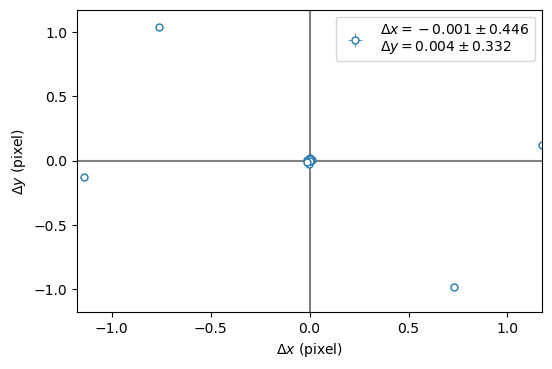

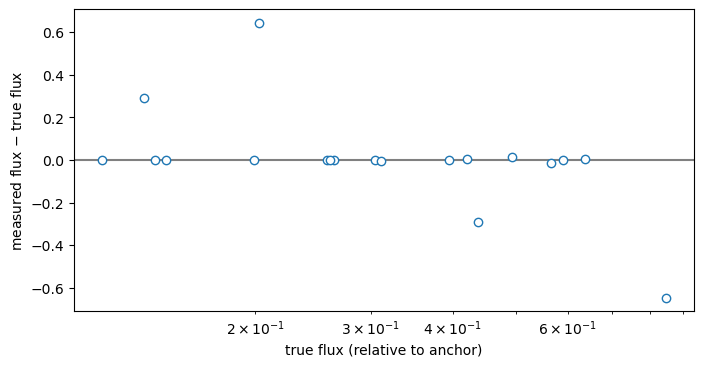

In [65]:
check_solution(popt['xcenters_drop'], popt['ycenters_drop'], np.exp(popt['lnfluxes_drop'])/fluxes_guess[idx_anchor],
               xdrop, ydrop, fdrop)

In [66]:
psf_pred, image_pred = gridpsf.gp_marginal(jnp.exp(popt['lnfluxes']), popt['xcenters'], popt['ycenters'], 
                            jnp.exp(popt['lnlenx']), jnp.exp(popt['lnleny']), jnp.exp(2*popt['lnamp']),
                            image_obs, sigmaerr, image_super, S, return_pred=True)

In [67]:
meanpsf = psf_pred.reshape(*gridpsf.shape)
meanpsf /= np.sum(meanpsf)
truepsf = simulate_gaussian_sources(gridpsf, np.array([1.]), np.array([0.]), np.array([0.]), 1.)
truepsf /= np.sum(truepsf)

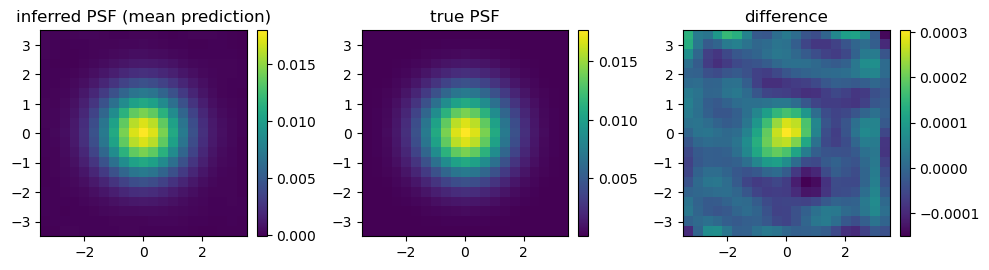

In [68]:
check_PSF_fit(gridpsf, meanpsf, truepsf)

/home/masuda/repos/bepsf/src/bepsf/utils.py:92: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(ylim)


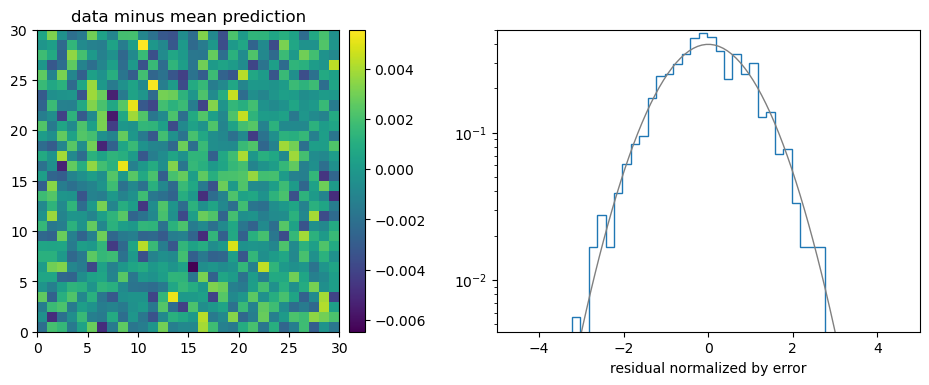

In [69]:
check_image_fit(image_obs, sigmaerr, image_pred)

In [70]:
mcmc = run_hmc(gridpsf, image_obs, sigmaerr, image_super, S, idx_anchor, popt)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
warmup:   3%|█▋                                               | 34/1000 [01:41<48:08,  2.99s/it, 127 steps of size 7.12e-06. acc. prob=0.74]


KeyboardInterrupt: 

In [24]:
import corner
import pandas as pd
from arviz import plot_trace

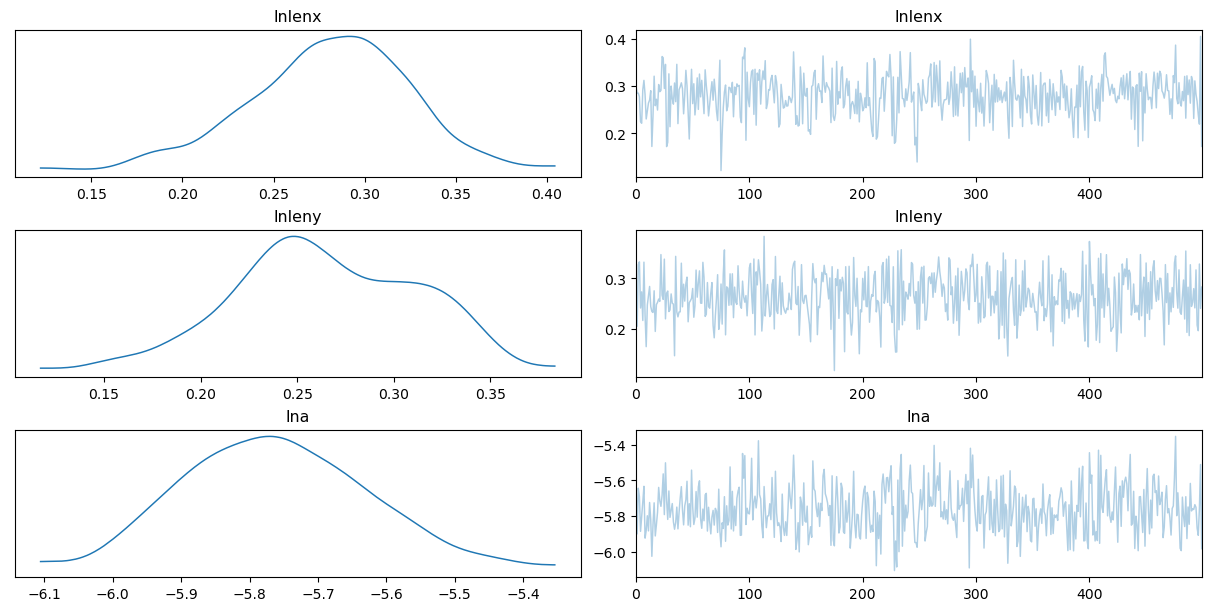

In [25]:
fig = plot_trace(mcmc, var_names=['lnlenx', 'lnleny', 'lna'])

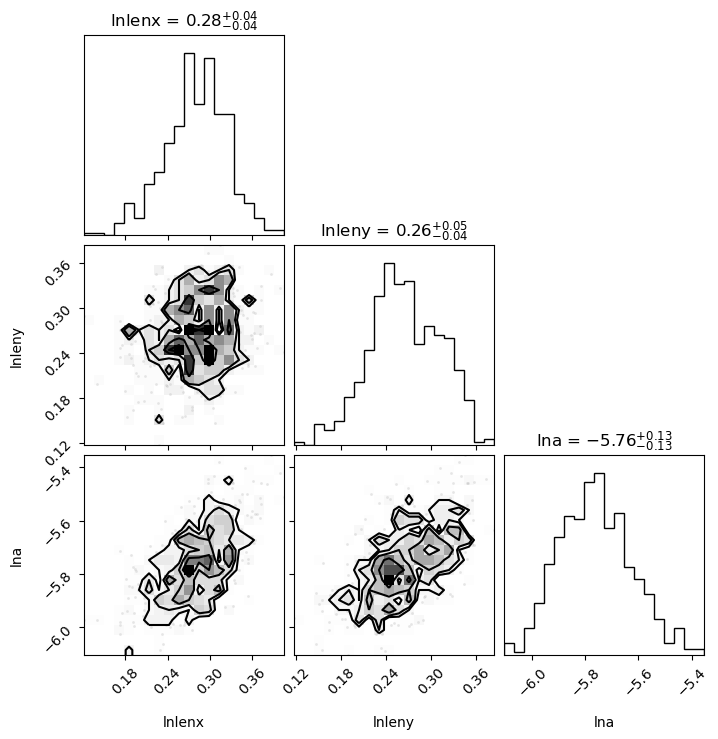

In [26]:
pnames = ["lnlenx", "lnleny", "lna"]
hyper = pd.DataFrame(data=dict(zip(pnames, [mcmc.get_samples()[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")

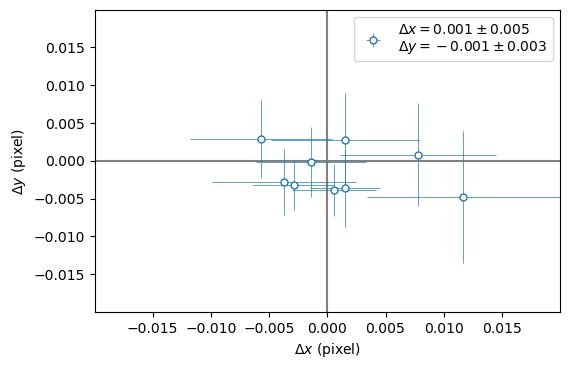

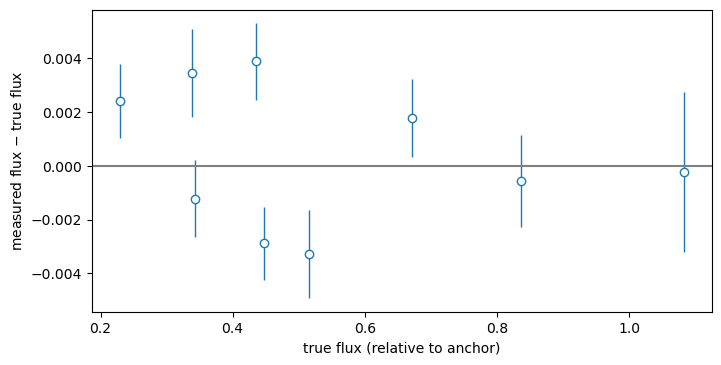

In [28]:
smp = mcmc.get_samples()
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0), np.std(smp['y'], axis=0)
fmean, fstd = np.mean(smp['f'], axis=0), np.std(smp['f'], axis=0)
f_anchor = np.exp(lnfluxes_guess[idx_anchor])
fmean /= f_anchor
fstd /= f_anchor
check_solution(xmean, ymean, fmean, xdrop, ydrop, fdrop, xstd, ystd, fstd)